# Hand-written digit generation using GAN with generator and discriminator as multi-layer perceptrons.

In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

<h3>Set device</h3>

In [2]:
device = 'cuda'

<h3>Generator</h3>

In [3]:
class Generator(nn.Module):
    
    """
    Multi-layer Perceptron as the generator of GAN.
    
    Parameters
    ----------
    noise_dim: int
        dimension of the random noise vector drawn from latent space.
    hidden_dims: tuple
        tuple of dimensions of hidden layers.
    image_dim: int
        dimension of the flattened image generated.
    """
    
    def __init__(self, noise_dim = 64, hidden_dims = (), image_dim = 784):
        
        super(Generator, self).__init__()
        
        layers_list = [] # list of hidden layers and output layer in MLP.
        
        curr_input_dim = noise_dim # initial input dimension.
        
        for hidden_dim in hidden_dims: # add hidden layers to the list
            layer = nn.Sequential(nn.Linear(curr_input_dim, hidden_dim),
                                  nn.BatchNorm1d(hidden_dim),
                                  nn.ReLU())
            layers_list.append(layer)
            curr_input_dim = hidden_dim
            
        layer = nn.Sequential(nn.Linear(hidden_dim,image_dim),nn.Sigmoid()) # add output layer to the list
        layers_list.append(layer)
        
        self.generator = nn.Sequential(*layers_list) # build generator
    
    def forward(self, noise_vectors):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        noise_vectors: Tensor
            batch of random noise vectors.

        Returns
        -------
        images: Tensor
            images generated from the noise vectors.
        """
        
        images = self.generator(noise_vectors)
        return images

<h3>Discriminator</h3>

In [4]:
class Discriminator(nn.Module):
    
    """
    Multi-layer Perceptron as the discriminator of GAN.

    image_dim: int
        dimension of a flattened image.
    hidden_dims: tuple
        tuple of dimensions of hidden layers.
    """
    
    def __init__(self, image_dim = 784, hidden_dims = ()):
        
        super(Discriminator, self).__init__()
        
        layers_list = []
        
        curr_input_dim = image_dim
        
        for hidden_dim in hidden_dims:
            layer = nn.Sequential(nn.Linear(curr_input_dim, hidden_dim), nn.LeakyReLU(negative_slope = 0.2))
            layers_list.append(layer)
            curr_input_dim = hidden_dim
            
        layer = nn.Sequential(nn.Linear(hidden_dim,1), nn.Sigmoid()) # add output layer to the list
        layers_list.append(layer)
        
        self.discriminator = nn.Sequential(*layers_list)
    
    def forward(self, images):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        images:
            batch of images.

        Returns
        -------
        predictions: Tensor
            binary predictions of the input images.
        """
        
        predictions = self.discriminator(images)
        return predictions

<h3>function to compute generator's loss</h3>

In [5]:
def get_generator_loss(generator, discriminator, criterion, noise_vectors):
    
    """

    Compute the binary cross entropy loss of the generator.

    Parameters
    ----------
    generator: Generator
        generator object
    discriminator: Discriminator
        discriminator object
    criterion: BCELoss
        object to compute generator's loss
    noise_vectors: Tensor
        batch of random noise vectors

    Returns
    -------
    loss: Tensor
        generator's BCE loss.
    """
    
    fake_images = generator(noise_vectors)
    fake_pred = discriminator(fake_images)
    fake_target = torch.ones_like(fake_pred)
    loss = criterion(fake_pred, fake_target)
    
    return loss

<h3>function to compute discriminator's loss</h3>

In [6]:
def get_discriminator_loss(generator, discriminator, criterion, noise_vectors, real_images):
    
    """
    Compute the binary cross entropy loss of the generator.

    Parameters
    ----------
    generator: Generator
        generator object
    discriminator: Discriminator
        discriminator object
    criterion: BCELoss
        object to compute generator's loss
    noise_vectors: 
        batch of random noise vectors
    real_images: 
        batch of real images

    Returns
    -------
    loss: Tensor
        discriminator's BCE loss.
    """
    
    loss = 0
    
    fake_images = generator(noise_vectors)
    fake_pred = discriminator(fake_images)
    fake_target = torch.zeros_like(fake_pred)
    loss += criterion(fake_pred, fake_target)
    
    real_pred = discriminator(real_images)
    real_target = torch.ones_like(real_pred)
    loss += criterion(real_pred, real_target)
    
    return loss

<h3>function to show generated images</h3>

In [7]:
def show_images(images, image_size = (28,28)):
    
    """
    Show the grid of images.

    Parameters
    ----------
    images: Tensor
        batch of images to be displayed.
    image_size: tuple
        size of an image.

    Returns
    -------
    None
    """

    images = images.detach().cpu().view(-1, *image_size)
    image_grid = make_grid(images, nrow = 5).permute(1,2,0)
    plt.imshow(image_grid)
    plt.show()

<h3>set noise dimension and image dimension</h3>

In [8]:
noise_dim = 64

image_dim = 784

<h3>create generator</h3>

Architecture of generator:<br>

|  Layer  |  Number of Neurons  |
|:-------:|:-------------------:|
|  Input  |         64          |
| Hidden 1|        128          |
| Hidden 2|        256          |
| Hidden 3|        512          |
| Output  |        784          |

All hidden layers use batch normalization and ReLU activation function.<br>
Output layer uses sigmoid activation function.

In [9]:
generator = Generator(noise_dim = noise_dim, hidden_dims = (128,256,512), image_dim = image_dim).to(device)

<h3>create discriminator</h3>

Architecture of discriminator:<br>

|  Layer  |  Number of Neurons  |
|:-------:|:-------------------:|
|  Input  |        784          |
| Hidden 1|        256          |
| Hidden 2|        128          |
| Output  |         1           |

All hidden layers use LeakyReLU activation function.<br>
Output layer uses sigmoid activation function.

In [10]:
discriminator = Discriminator(image_dim = image_dim, hidden_dims = (256, 128)).to(device)

<h3>train GAN</h3>

In [11]:
num_epochs = 100 # number of epochs

batch_size = 64 # number of images in a batch

criterion = nn.BCELoss() # object to compute loss of generator and discriminator

learning_rate = 0.0001 # larning rate of the optimizers

generator_optim = torch.optim.Adam(generator.parameters(), lr = learning_rate) # generator's optimizer

discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr = learning_rate) # discriminator's optimizer

# MNIST data loader
data_loader = DataLoader(MNIST('.', download = True, transform = transforms.ToTensor()), 
                        batch_size = batch_size, shuffle = True)

for epoch in range(num_epochs):

    mean_generator_loss = 0
    mean_discriminator_loss = 0
    counter = 0
    
    for real_images, _ in tqdm(data_loader):
        
        curr_batch_size = real_images.shape[0] # number of real images in a batch
        real_images = real_images.view(curr_batch_size, -1).to(device) # flatten images
        
        # train discriminator
        
        noise_vectors = torch.randn(curr_batch_size, noise_dim, device = device) # random noise vectors
        discriminator_optim.zero_grad() # set gradients of tensors to 0.
        discriminator_loss = get_discriminator_loss(generator, discriminator, criterion, noise_vectors, real_images)
        discriminator_loss.backward(retain_graph = True) # compute the gradients
        discriminator_optim.step() # optimize using gradients
        
        # train generator
        
        noise_vectors = torch.randn(curr_batch_size, noise_dim, device = device) # random noise vectors
        generator_optim.zero_grad() # set gradients of tensors to 0.
        generator_loss = get_generator_loss(generator, discriminator, criterion, noise_vectors)
        generator_loss.backward(retain_graph = True) # compute the gradients
        generator_optim.step() # optimize using gradients

        mean_generator_loss += generator_loss.item()
        mean_discriminator_loss += discriminator_loss.item()
        counter += 1
    
    mean_generator_loss /= counter
    mean_discriminator_loss /= counter
    
    # print current losses
    print(f"Epoch {epoch+1} : Generator's loss : {mean_generator_loss}, Discriminator's loss : {discriminator_loss}")

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1 : Generator's loss : 3.256807330130006, Discriminator's loss : 0.22605881094932556


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2 : Generator's loss : 3.0397815107028365, Discriminator's loss : 0.20183905959129333


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3 : Generator's loss : 3.6494465367372104, Discriminator's loss : 0.22471848130226135


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4 : Generator's loss : 3.849005405328421, Discriminator's loss : 0.25509870052337646


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5 : Generator's loss : 3.7056641728639095, Discriminator's loss : 0.31842607259750366


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6 : Generator's loss : 3.43456810115497, Discriminator's loss : 0.23442873358726501


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7 : Generator's loss : 3.729855144455997, Discriminator's loss : 0.05555247515439987


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8 : Generator's loss : 3.6259237520221963, Discriminator's loss : 0.15071719884872437


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9 : Generator's loss : 3.7523229259417765, Discriminator's loss : 0.12519443035125732


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 : Generator's loss : 3.6331344517563453, Discriminator's loss : 0.4770526587963104


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11 : Generator's loss : 3.627100773457525, Discriminator's loss : 0.5310137271881104


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12 : Generator's loss : 3.6006111536961374, Discriminator's loss : 0.38925060629844666


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13 : Generator's loss : 3.480417601843633, Discriminator's loss : 0.2167520672082901


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14 : Generator's loss : 3.296040732977487, Discriminator's loss : 0.3410938084125519


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15 : Generator's loss : 3.1489219421516856, Discriminator's loss : 0.3984229862689972


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16 : Generator's loss : 3.218232030044995, Discriminator's loss : 0.20431172847747803


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17 : Generator's loss : 3.1886589733013975, Discriminator's loss : 0.35082635283470154


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18 : Generator's loss : 3.12412226911801, Discriminator's loss : 0.5450780391693115


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19 : Generator's loss : 3.102412300069195, Discriminator's loss : 0.5465497970581055


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20 : Generator's loss : 2.991944268568238, Discriminator's loss : 0.2783592939376831


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21 : Generator's loss : 2.745714434809776, Discriminator's loss : 0.7868682742118835


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 22 : Generator's loss : 2.821824159957707, Discriminator's loss : 0.6490225791931152


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 23 : Generator's loss : 2.834237890202862, Discriminator's loss : 0.6388153433799744


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 24 : Generator's loss : 2.73166898572877, Discriminator's loss : 0.4634142518043518


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 25 : Generator's loss : 2.721757285884703, Discriminator's loss : 0.4553174376487732


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26 : Generator's loss : 2.5988453456333707, Discriminator's loss : 0.635106086730957


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 27 : Generator's loss : 2.590311109257151, Discriminator's loss : 0.7711648941040039


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 28 : Generator's loss : 2.5122068641282347, Discriminator's loss : 0.27825140953063965


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 29 : Generator's loss : 2.38555571278021, Discriminator's loss : 0.5510509610176086


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 30 : Generator's loss : 2.2939269186845466, Discriminator's loss : 0.5908147096633911


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 31 : Generator's loss : 2.2557913275924064, Discriminator's loss : 0.7113364934921265


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 32 : Generator's loss : 2.18411962106538, Discriminator's loss : 0.7584530115127563


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 33 : Generator's loss : 2.168990350862556, Discriminator's loss : 0.5979574918746948


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 34 : Generator's loss : 2.0691979152561504, Discriminator's loss : 0.720600962638855


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 35 : Generator's loss : 2.0180707314629545, Discriminator's loss : 0.6761780977249146


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 36 : Generator's loss : 2.003001890838273, Discriminator's loss : 0.7968302369117737


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37 : Generator's loss : 1.9740481348688415, Discriminator's loss : 0.8681185841560364


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 38 : Generator's loss : 2.0217363637393473, Discriminator's loss : 0.6447357535362244


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 39 : Generator's loss : 1.9490159687711233, Discriminator's loss : 0.8205586671829224


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 40 : Generator's loss : 1.9012658134706493, Discriminator's loss : 0.6699859499931335


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 41 : Generator's loss : 1.8353114089986156, Discriminator's loss : 0.8236761093139648


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42 : Generator's loss : 1.8141870383006424, Discriminator's loss : 0.7042979001998901


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 43 : Generator's loss : 1.7631252959593018, Discriminator's loss : 0.6212539672851562


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 44 : Generator's loss : 1.733060197026999, Discriminator's loss : 0.7839727401733398


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 45 : Generator's loss : 1.7046882372929344, Discriminator's loss : 0.891986608505249


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 46 : Generator's loss : 1.7084206805300357, Discriminator's loss : 0.7885351777076721


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47 : Generator's loss : 1.6594219165824369, Discriminator's loss : 0.9611965417861938


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 48 : Generator's loss : 1.681504180690627, Discriminator's loss : 0.8200210332870483


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 49 : Generator's loss : 1.6200217463568585, Discriminator's loss : 0.8514953851699829


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 50 : Generator's loss : 1.5786345757401066, Discriminator's loss : 0.7425694465637207


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 51 : Generator's loss : 1.5688783104485795, Discriminator's loss : 0.8691436052322388


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 52 : Generator's loss : 1.6032198475622166, Discriminator's loss : 0.6804443597793579


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 53 : Generator's loss : 1.5035864274893234, Discriminator's loss : 0.8034718036651611


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 54 : Generator's loss : 1.4950929604359526, Discriminator's loss : 0.9957557916641235


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 55 : Generator's loss : 1.489979995720422, Discriminator's loss : 0.9366664290428162


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 56 : Generator's loss : 1.4763445850374348, Discriminator's loss : 0.8055148720741272


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 57 : Generator's loss : 1.4907233093593166, Discriminator's loss : 0.9809208512306213


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 58 : Generator's loss : 1.4409219684885508, Discriminator's loss : 0.842742383480072


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 59 : Generator's loss : 1.4663569371837544, Discriminator's loss : 0.9284770488739014


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 60 : Generator's loss : 1.4981423245310022, Discriminator's loss : 0.9857497215270996


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 61 : Generator's loss : 1.4199185502300384, Discriminator's loss : 0.8331016302108765


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 62 : Generator's loss : 1.4189784656455522, Discriminator's loss : 1.0508978366851807


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 63 : Generator's loss : 1.3844014326138283, Discriminator's loss : 0.9397780299186707


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 64 : Generator's loss : 1.4620587431799883, Discriminator's loss : 1.051853060722351


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 65 : Generator's loss : 1.3750844367785748, Discriminator's loss : 0.9821964502334595


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 66 : Generator's loss : 1.3726831124281325, Discriminator's loss : 0.8370354175567627


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 67 : Generator's loss : 1.3577606703426792, Discriminator's loss : 0.6932132244110107


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 68 : Generator's loss : 1.3886822472884457, Discriminator's loss : 0.9931811094284058


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 69 : Generator's loss : 1.3660082961958864, Discriminator's loss : 1.19376540184021


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 70 : Generator's loss : 1.4060100881275592, Discriminator's loss : 0.8511685729026794


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 71 : Generator's loss : 1.382382206634672, Discriminator's loss : 1.0578312873840332


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 72 : Generator's loss : 1.3421666110629467, Discriminator's loss : 0.9645287990570068


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 73 : Generator's loss : 1.3114898490753255, Discriminator's loss : 1.0648846626281738


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 74 : Generator's loss : 1.308356448531405, Discriminator's loss : 1.1336688995361328


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 75 : Generator's loss : 1.3150618938621936, Discriminator's loss : 0.9350675940513611


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 76 : Generator's loss : 1.31069648488244, Discriminator's loss : 1.0189664363861084


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 77 : Generator's loss : 1.2995985368294503, Discriminator's loss : 0.7443974614143372


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 78 : Generator's loss : 1.2886743888671972, Discriminator's loss : 1.1422619819641113


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 79 : Generator's loss : 1.289604704326658, Discriminator's loss : 1.2437976598739624


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 80 : Generator's loss : 1.2941566808010214, Discriminator's loss : 0.8297871351242065


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 81 : Generator's loss : 1.2875812398091053, Discriminator's loss : 1.1714807748794556


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 82 : Generator's loss : 1.3039977722711908, Discriminator's loss : 1.1123416423797607


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 83 : Generator's loss : 1.2756976557057549, Discriminator's loss : 1.0813063383102417


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 84 : Generator's loss : 1.2858254632461807, Discriminator's loss : 0.6352331638336182


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 85 : Generator's loss : 1.36334619167517, Discriminator's loss : 1.06883704662323


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 86 : Generator's loss : 1.2738492478693981, Discriminator's loss : 1.067600965499878


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 87 : Generator's loss : 1.2724490200024423, Discriminator's loss : 0.892508864402771


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 88 : Generator's loss : 1.2695851478495324, Discriminator's loss : 1.1351221799850464


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 89 : Generator's loss : 1.2517464871345552, Discriminator's loss : 1.216843843460083


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 90 : Generator's loss : 1.2609902953923637, Discriminator's loss : 1.0235233306884766


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 91 : Generator's loss : 1.2530318536102645, Discriminator's loss : 0.9537916779518127


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 92 : Generator's loss : 1.2465043948022032, Discriminator's loss : 1.0881540775299072


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 93 : Generator's loss : 1.2621744053958575, Discriminator's loss : 0.9408250451087952


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 94 : Generator's loss : 1.2726949651612403, Discriminator's loss : 1.028221845626831


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 95 : Generator's loss : 1.2487493212670406, Discriminator's loss : 0.9187533259391785


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 96 : Generator's loss : 1.2364295765535156, Discriminator's loss : 1.180159568786621


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 97 : Generator's loss : 1.230656855205483, Discriminator's loss : 0.9681429266929626


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 98 : Generator's loss : 1.2315478324890137, Discriminator's loss : 0.9563007950782776


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 99 : Generator's loss : 1.249236018355213, Discriminator's loss : 0.8979732990264893


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 100 : Generator's loss : 1.2221940075919064, Discriminator's loss : 1.0239030122756958


<h3>generate images using trained GAN</h3>

In [12]:
num_images = 20

noise_vectors = torch.randn(num_images, noise_dim, device = device)

fake_images = generator(noise_vectors)

<h3>show fake images</h3>

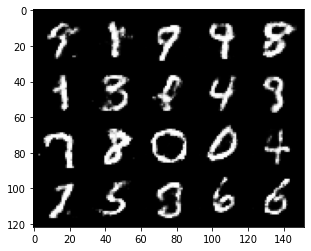

In [13]:
show_images(fake_images, (1,28,28))

<h3>show real images</h3>

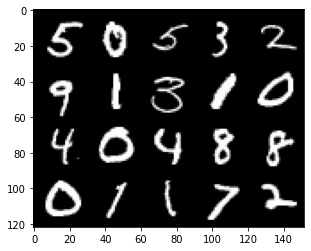

In [14]:
real_images = real_images[:20].view(-1, 28, 28)

show_images(real_images, (1, 28, 28))